<h3>MasterCard Stock Price Prediction Using LSTM & GRU</h3>

Recurrent Neural Networks (RNNs) are a specialized class of artificial neural networks designed for processing sequential data. Unlike traditional feedforward neural networks that treat inputs independently, RNNs leverage the temporal dependencies in data, making them particularly effective for tasks such as language translation, speech recognition, and time series forecasting.


Use Kaggle’s MasterCard stock dataset from May-25-2006 to Oct-11-2021 and train the LSTM and GRU models to forecast the stock price.

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.random import set_seed
set_seed(455)
np.random.seed(455)

Import the MasterCard dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Mastercard_stock_history.csv to Mastercard_stock_history.csv


In [5]:
dataset = pd.read_csv(
    "Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())


                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


The .describe() function helps us analyze the data in depth. Let’s focus on the High column as we are going to use it to train the model. We can also choose Close or Open columns for a model feature, but High makes more sense as it provides us information of how high the values of the share went on the given day.

The minimum stock price is $4.10, and the highest is $400.5. The mean is at $105.9 and the standard deviation $107.3, which means that stocks have high variance

In [6]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


In [7]:
#check missing values
dataset.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


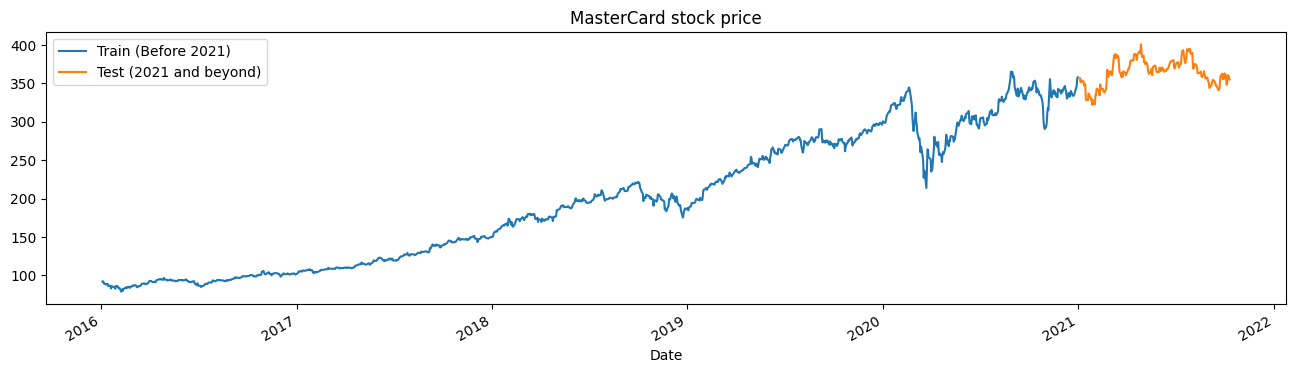

In [8]:

# Define start and end years for training data
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    """
    Plots the training and testing datasets for stock prices over specified time periods.

    Parameters:
    dataset (pd.DataFrame): A DataFrame containing stock price data with a DateTime index.
                            It should have a column named "High" representing the stock's high prices.
    tstart (int): The start year for the training dataset.
    tend (int): The end year for the training dataset.

    The function will plot:
    - The "High" prices from `tstart` to `tend` as the training dataset.
    - The "High" prices from the year after `tend` onward as the testing dataset.

    The resulting plot will include a legend indicating which part of the data is used for training
    and which part is used for testing, along with a title indicating that it represents MasterCard's stock price.
    """

    # Plotting the training data
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)

    # Plotting the testing data
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)

    # Adding legend and title
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")

    # Displaying the plot
    plt.show()

# Call the function to plot
train_test_plot(dataset, tstart, tend)


In [11]:
# divide the dataset into two subsets: training_set and test_set
def train_test_split(dataset, tstart, tend):
  train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
  test = dataset.loc[f"{tend+1}":, "High"].values
  return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

- Standardization

We will use the MinMaxScaler function to standardize our training set, which will help us avoid the outliers or anomalies. You can also try using StandardScaler or any other scalar function to normalize your data and improve model performance.

In [12]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [13]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [14]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],features)

<h3>LSTM Model</h3>
Long Short-Term Memory is a specialized type of recurrent neural network that is capable of retaining information over long periods addressing vanishing gradient descent problem.

In [17]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", return_sequences=True, input_shape=(n_steps, features)))
model_lstm.add(Dropout(0.2))  # 20% dropout
model_lstm.add(LSTM(units=64, activation="tanh"))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 60, 125)             │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 125)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          48,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,205 (438.30 KB)

 Trainable params: 112,205 (438.30 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_lstm.fit(X_train, y_train, epochs=40, batch_size=32)

Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.0411
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.0069
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.0054
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.0052
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.0052
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 0.0040
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0044
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - loss: 0.0047
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.0036
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0028
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.0043
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0027
Epoch 13/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - loss: 0.0029
Epoch 14/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 0.0028
Epoch 15/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - l

We are going to repeat preprocessing and normalize the test set. First of all we will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form.

In [19]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


The plot_predictions function will plot a real versus predicted line chart. This will help us visualize the difference between actual and predicted values.

The return_rmse function takes in test and predicted arguments and prints out the root mean square error (rmse) metric.

In [24]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))
from sklearn.metrics import mean_squared_error, r2_score


def calculate_accuracy_metrics(test, predicted):
    """Calculates and prints various accuracy metrics."""
    # Ensure inputs are numpy arrays for consistency
    test = np.array(test)
    predicted = np.array(predicted)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predicted))

    # Calculate R-squared
    r_squared = r2_score(test, predicted)

    # Calculate MAPE
    mape = np.mean(np.abs((test - predicted) / test)) * 100

    # Print results
    print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
    print("R-squared (R²): {:.2f}".format(r_squared))
    print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

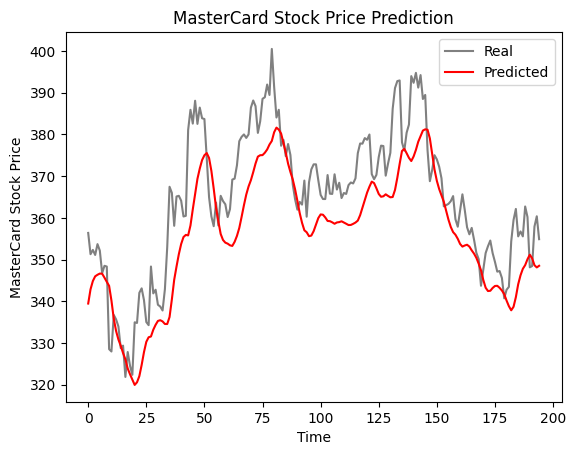

In [21]:
plot_predictions(test_set,predicted_stock_price)


In [22]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 11.29.


In [25]:
#check accuracy metrics
calculate_accuracy_metrics(test_set, predicted_stock_price)


Root Mean Squared Error (RMSE): 11.29
R-squared (R²): 0.55
Mean Absolute Percentage Error (MAPE): 5.29%


The perfomance is relatively good.But there is room for improvement
Steps i plan to implement in the future to counter potential underfitting with the poor explained variance of .55

- Consider more complex architectures
- Hyperparameter tuning
- Feature engineering

<h4>GRU Models - a simple alternative to LSTMs</h4>

In [26]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 125)                 │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0401
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0022
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0012
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 7.9366e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 8.5016e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 7.7292e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 7.3473e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 6.8749e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 6.4305e-04 
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.9460e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 6.5251e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 5.5671e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


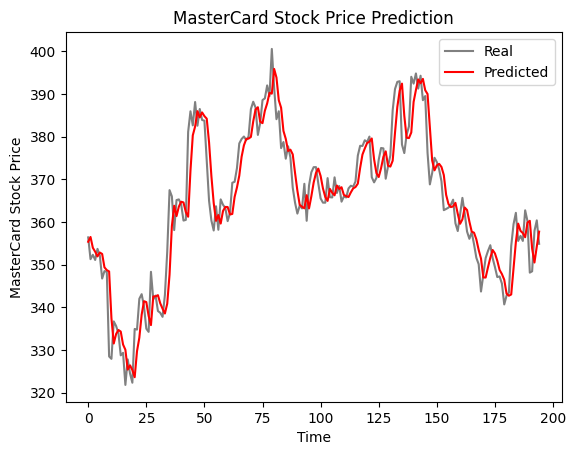

In [28]:
#view results

GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)


In [29]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.84.


In [30]:
#check accuracy metrics
calculate_accuracy_metrics(test_set, GRU_predicted_stock_price)


Root Mean Squared Error (RMSE): 5.84
R-squared (R²): 0.88
Mean Absolute Percentage Error (MAPE): 5.23%
